# Analysis of adversarial training experiments

**Evaluating deconfounding strat**
1. prediction performance of advNet (does it learn something?)
2. deconfounding performance (does it work?)
   
**Evaluation clustering**
1. clustering of cancer types on deconfounded embedding 
2. association between clustering & confounders

**Evaluation training?**

In [1]:
''' Model information '''
firstEpoch = "epoch1"
lastEpoch = "epoch10"
modelName = "artificial2/advTraining_multiclass_1batch"
print(modelName)

artificial2/advTraining_multiclass_1batch


In [2]:
import sys
sys.path.append("../../../")
import os
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as L
import torch.utils.data as data
from data.preprocess import ConcatDataset
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, roc_auc_score, r2_score
from scipy.stats import pearsonr
from models.func import kld, mmd, reconAcc_pearsonCorr, reconAcc_relativeError, mse, crossEntropy, bce, init_weights
from models.clustering import *

from models.adversarial_XVAE_multiclass_1batch import XVAE_w_advNet_pingpong

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Load data & model

In [3]:

''' Set seeds for replicability  -Ensure that all operations are deterministic on GPU (if used) for reproducibility '''
np.random.seed(1234)
torch.manual_seed(1234)
L.seed_everything(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

''' Set PATHs '''
PATH_data = "../../../Data"

X1 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_mRNAs_confounded.csv'), delimiter=",")
X2 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_miRNAs_confounded.csv'), delimiter=",")
X1 = torch.from_numpy(X1).to(torch.float32)
X2 = torch.from_numpy(X2).to(torch.float32)
traits = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_clinic.csv'), delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
# Get traits
Y = traits[:, -1]
artificialConf = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_confounder.csv'), delimiter=",")[:,None]


''' Split into training and validation sets '''
n_samples = X1.shape[0]
indices = np.random.permutation(n_samples)
train_idx, val_idx, test_idx = indices[:2100], indices[2100:2700], indices[2700:]

X1_train, X1_val, X1_test = X1[train_idx,:], X1[val_idx,:], X1[test_idx,:]
X2_train, X2_val, X2_test = X2[train_idx,:], X2[val_idx,:], X2[test_idx,:] 
Y_test = Y[test_idx]


''' Load confounders '''

# Take only age as confounder and scale
conf = OneHotEncoder(sparse_output=False, drop="if_binary").fit_transform(artificialConf)
print("\n",{conf.shape})
labels_onehot = [f"artificalConf{i}" for i in range(conf.shape[1])] #,'Gender','Race1', 'Race2', 'Race3'] #"Gender", 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Race1', 'Race2', 'Race3']
print('Shape of confounders:', conf.shape)

conf_train, conf_val, conf_test = conf[train_idx,], conf[val_idx,], conf[test_idx,] 


Global seed set to 1234



 {(3024, 6)}
Shape of confounders: (3024, 6)


## 1. Check prediction performance of advNet

In [4]:
ckpt_advNet_path = f"../../../lightning_logs/{modelName}/XVAE_adv_pingpong/{lastEpoch}/checkpoints"
ckpt_advNet_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"
model = XVAE_w_advNet_pingpong.load_from_checkpoint(ckpt_advNet_file)

In [5]:
_, y_pred_all = model.advNet_pre.forward(X1_test,X2_test)
y_pred_all = [y_pred_all[i].detach().numpy() for i in range(len(y_pred_all))]
y_pred = pd.DataFrame(y_pred_all, columns=labels_onehot)
y_true =  pd.DataFrame(conf_test, columns=labels_onehot)

### Discrete vars
for col in labels_onehot:
    print(col, "\t", round(roc_auc_score(y_true.loc[:,col],y_pred.loc[:,col]),2))

artificalConf0 	 0.98
artificalConf1 	 0.98
artificalConf2 	 1.0
artificalConf3 	 0.99
artificalConf4 	 0.98
artificalConf5 	 0.99


/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## 2. Check deconfounding performance

In [6]:
all_corr = []
dic_res = dict()
for i in range(2):
    ##########
    ### Because of the variational part the latent space is always a bit different and these values change
    ##########
    for epoch in [firstEpoch, lastEpoch]:

        ckpt_path = f"../../../lightning_logs/{modelName}/XVAE_adv_pingpong/{epoch}/checkpoints"
        ckpt_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"
        model = XVAE_w_advNet_pingpong.load_from_checkpoint(ckpt_file)

        z = model.xvae_pre.generate_embedding(X1_test, X2_test).detach().numpy()

        corr_conf = [np.abs(np.corrcoef(z.T, conf_test[:,i].T)[:-1,-1]) for i in range(conf.shape[1])]
        
        dic_res[epoch] = pd.DataFrame(corr_conf, index=labels_onehot)

    ''' 
    Calculate [%] differences of correlation of confounders to each latent feature before (epoch1) and after training (epoch100)

    Formula:
    ((first epoch) - (last epoch)).mean() / (first epoch).mean()
    '''
    all_corr.append(list(((dic_res[firstEpoch].T - dic_res[lastEpoch].T).mean() / dic_res[firstEpoch].T.mean())*100))

## Analyse
all_corr_unpacked = list(zip(*all_corr))
corr_dict = dict()
for i, label in enumerate(labels_onehot):
    corr_dict[label] = np.array(all_corr_unpacked[i]).mean()

pd.DataFrame(corr_dict, index=[0]).round(2).T

,0
artificalConf0,-0.91
artificalConf1,0.18
artificalConf2,0.36
artificalConf3,-1.09
artificalConf4,-0.34
artificalConf5,0.48


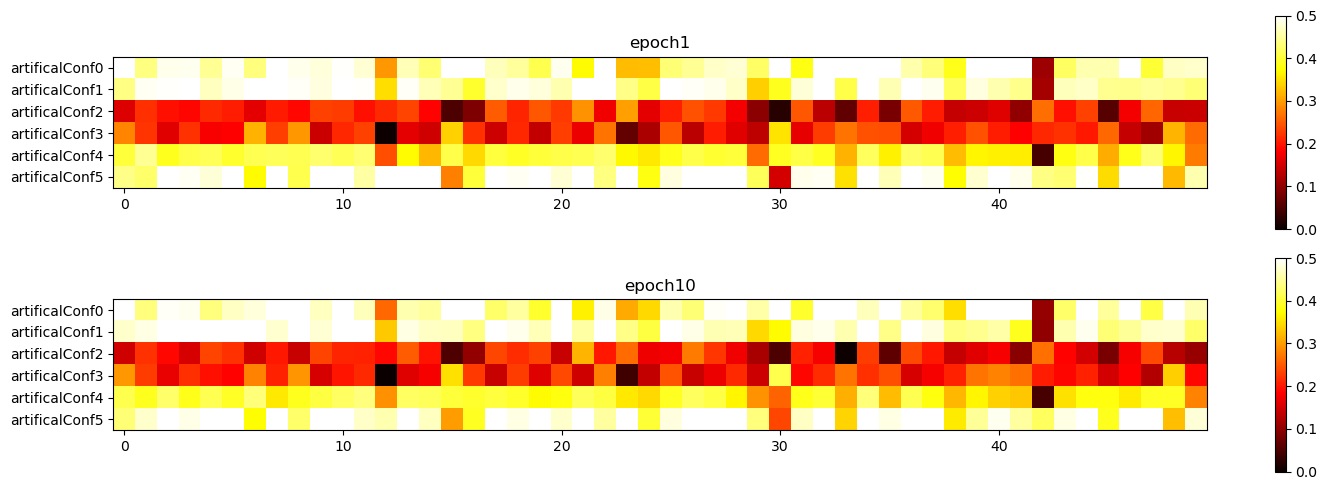

In [7]:
''' Plot heatmap '''

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,5))
im = ax1.imshow(dic_res[firstEpoch], cmap='hot', interpolation='nearest', vmin=0, vmax=0.5)
ax1.set_yticks(np.arange(conf.shape[1]), labels=labels_onehot)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_title(firstEpoch)
plt.colorbar(im)
##
im = ax2.imshow(dic_res[lastEpoch], cmap='hot', interpolation='nearest',vmin=0, vmax=0.5)
ax2.set_yticks(np.arange(conf.shape[1]), labels=labels_onehot)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_title(lastEpoch)
plt.colorbar(im)
plt.tight_layout()

## 3. Clustering 
- of cancer types (on deconfounded embedding)
-  Association between clustering and confounders

In [8]:
ckpt_advNet_path = f"../../../lightning_logs/{modelName}/XVAE_adv_pingpong/{lastEpoch}/checkpoints"
ckpt_advNet_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"
model = XVAE_w_advNet_pingpong.load_from_checkpoint(ckpt_advNet_file)

LF = model.xvae_pre.generate_embedding(X1_test, X2_test).detach().cpu().numpy()
Y = Y_test

In [9]:
clust = kmeans(LF, model.xvae_pre.c)
SS, DB = internal_metrics(LF, clust)
ARI, NMI = external_metrics(clust, Y)

pd.DataFrame([SS, DB, ARI, NMI], index=["SS", "DB", "ARI", "NMI"])

,0
SS,0.131325
DB,2.357139
ARI,-0.001318
NMI,0.022178


In [10]:
conf_assoc = test_confounding(clust, conf_test)
pd.DataFrame([conf_assoc[i] for i,label in enumerate(labels_onehot)], index=labels_onehot)

,0
artificalConf0,1.531211e-32
artificalConf1,2.386237e-38
artificalConf2,4.055102e-61
artificalConf3,2.680015e-61
artificalConf4,2.683757e-35
artificalConf5,4.956656e-37
